# Creating a CANDU bundle

In this example, we will create a typical CANDU bundle with rings of fuel pins. At present, OpenMC does not have a specialized lattice for this type of fuel arrangement, so we must resort to manual creation of the array of fuel pins.

In [1]:
%matplotlib inline
from math import pi, sin, cos
import numpy as np
import openmc

Let's begin by creating the materials that will be used in our model.

In [2]:
fuel = openmc.Material(name='fuel')
fuel.add_nuclide('U235', 1.0)
fuel.set_density('g/cm3', 4.5)

clad = openmc.Material(name='zircaloy')
clad.add_element('Zr', 1.0)
clad.set_density('g/cm3', 1.0)

heavy_water = openmc.Material(name='heavy water')
heavy_water.add_nuclide('H1', 1.0)
heavy_water.add_nuclide('H2', 1.0)
heavy_water.add_nuclide('O16', 1.0)
heavy_water.set_density('g/cm3', 1.0)

With out materials created, we'll now define key dimensions in our model. These dimensions are taken from the example in section 11.1.3 of the [Serpent manual](http://montecarlo.vtt.fi/download/Serpent_manual.pdf).

In [3]:
# Outer radius of fuel and clad
r_fuel = 0.6122
r_clad = 0.6540

# Pressure tube and calendria radii
pressure_tube_ir = 5.16890
pressure_tube_or = 5.60320
calendria_ir = 6.44780
calendria_or = 6.58750

# Radius to center of each ring of fuel pins
ring_radii = np.array([0.0, 1.4885, 2.8755, 4.3305])

To begin creating the bundle, we'll first create annular regions completely filled with heavy water and add in the fuel pins later. The radii that we've specified above correspond to the center of each ring. We actually need to create cylindrical surfaces at radii that are half-way between the centers.

In [4]:
# These are the surfaces that will divide each of the rings
radial_surf = [openmc.ZCylinder(R=r) for r in
               (ring_radii[:-1] + ring_radii[1:])/2]

water_cells = []
for i in range(ring_radii.size):
    # Create annular region
    if i == 0:
        water_region = -radial_surf[i]
    elif i == ring_radii.size - 1:
        water_region = +radial_surf[i-1]
    else:
        water_region = +radial_surf[i-1] & -radial_surf[i]
        
    water_cells.append(openmc.Cell(fill=heavy_water, region=water_region))

Let's see what our geometry looks like so far. In order to plot the geometry, we create a universe that contains the annular water cells and then use the `Universe.plot()` method. While we're at it, we'll set some keyword arguments that can be reused for later plots.

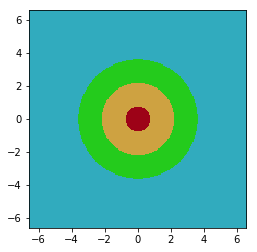

In [5]:
plot_args = {
    'width': (2*calendria_or, 2*calendria_or),
    'colors': {
        fuel: (1, 1, 0),
        clad: (1, 0, 0),
        heavy_water: (0, 0, 1)
        }
    }
bundle_universe = openmc.Universe(cells=water_cells)
bundle_universe.plot(**plot_args)

Now we need to create a universe that contains a fuel pin. Note that we don't actually need to put water outside of the cladding in this universe because it will be truncated by a higher universe.

In [6]:
surf_fuel = openmc.ZCylinder(R=r_fuel)

fuel_cell = openmc.Cell(fill=fuel, region=-surf_fuel)
clad_cell = openmc.Cell(fill=clad, region=+surf_fuel)

pin_universe = openmc.Universe(cells=(fuel_cell, clad_cell))

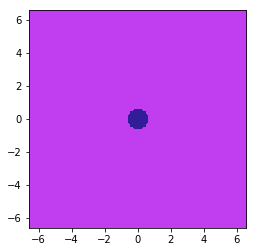

In [7]:
pin_universe.plot(**plot_args)

The code below works through each ring to create a cell containing the fuel pin universe. As each fuel pin is created, we modify the region of the water cell to include everything outside the fuel pin.

In [8]:
num_pins = [1, 6, 12, 18]
angles = [0, 0, 15, 0]

for i, (r, n, a) in enumerate(zip(ring_radii, num_pins, angles)):
    for j in range(n):
        # Determine location of center of pin
        theta = (a + j/n*360.) * pi/180.
        x = r*cos(theta)
        y = r*sin(theta)
        
        pin_boundary = openmc.ZCylinder(x0=x, y0=y, R=r_clad)
        water_cells[i].region &= +pin_boundary
        
        # Create each fuel pin -- note that we explicitly assign an ID so 
        # that we can identify the pin later when looking at tallies
        pin = openmc.Cell(fill=pin_universe, region=-pin_boundary)
        pin.translation = (x, y, 0)
        pin.id = (i + 1)*100 + j
        bundle_universe.add_cell(pin)

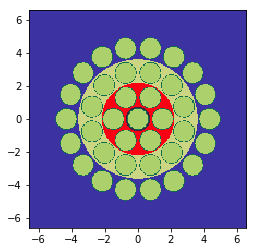

In [9]:
bundle_universe.plot(**plot_args)

Looking pretty good! Finally, we create cells for the pressure tube and calendria and then put our bundle in the middle of the pressure tube.

In [10]:
pt_inner = openmc.ZCylinder(R=pressure_tube_ir)
pt_outer = openmc.ZCylinder(R=pressure_tube_or)
calendria_inner = openmc.ZCylinder(R=calendria_ir)
calendria_outer = openmc.ZCylinder(R=calendria_or, boundary_type='vacuum')

bundle = openmc.Cell(fill=bundle_universe, region=-pt_inner)
pressure_tube = openmc.Cell(fill=clad, region=+pt_inner & -pt_outer)
v1 = openmc.Cell(region=+pt_outer & -calendria_inner)
calendria = openmc.Cell(fill=clad, region=+calendria_inner & -calendria_outer)

root_universe = openmc.Universe(0, cells=[bundle, pressure_tube, v1, calendria])

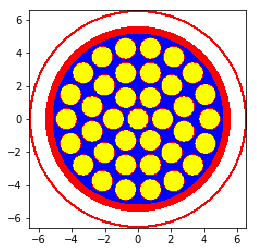

In [11]:
root_universe.plot(color_by='material', **plot_args)

In [12]:
geom = openmc.Geometry(root_universe)
geom.export_to_xml()

mats = openmc.Materials(geom.get_all_materials().values())
mats.export_to_xml()

In [13]:
settings = openmc.Settings()
settings.particles = 1000
settings.batches = 20
settings.inactive = 10
settings.source = openmc.Source(space=openmc.stats.Point())
settings.export_to_xml()

In [14]:
fuel_tally = openmc.Tally()
fuel_tally.filters = [openmc.DistribcellFilter(fuel_cell.id)]
fuel_tally.scores = ['flux']

tallies = openmc.Tallies([fuel_tally])
tallies.export_to_xml()

In [15]:
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

In [16]:
sp = openmc.StatePoint('statepoint.20.h5')

In [17]:
t = sp.get_tally()

In [18]:
t.get_pandas_dataframe()

level 1        level 2      level 3        distribcell nuclide score  \
      univ   cell    univ cell    univ   cell                             
        id     id      id   id      id     id                             
0        0  10043   10000  100   10001  10004           0   total  flux   
1        0  10043   10000  200   10001  10004           1   total  flux   
2        0  10043   10000  201   10001  10004           2   total  flux   
3        0  10043   10000  202   10001  10004           3   total  flux   
4        0  10043   10000  203   10001  10004           4   total  flux   
5        0  10043   10000  204   10001  10004           5   total  flux   
6        0  10043   10000  205   10001  10004           6   total  flux   
7        0  10043   10000  300   10001  10004           7   total  flux   
8        0  10043   10000  301   10001  10004           8   total  flux   
9        0  10043   10000  302   10001  10004           9   total  flux   
10       0  10043   10000  303   10001  10004          10   total  flux   
11       0  10043   10000  304   10001  10004          11   total  flux   
12       0  10043   10000  305   10001  10004          12   total  flux   
13       0  10043   10000  306   10001  10004          13   total  flux   
14       0  10043   10000  307   10001  10004          14   total  flux   
15       0  10043   10000  308   10001  10004          15   total  flux   
16       0  10043   10000  309   10001  10004          16   total  flux   
17       0  10043   10000  310   10001  10004          17   total  flux   
18       0  10043   10000  311   10001  10004          18   total  flux   
19       0  10043   10000  400   10001  10004          19   total  flux   
20       0  10043   10000  401   10001  10004          20   total  flux   
21       0  10043   10000  402   10001  10004          21   total  flux   
22       0  10043   10000  403   10001  10004          22   total  flux   
23       0  10043   10000  404   10001  10004          23   total  flux   
24       0  10043   10000  405   10001  10004          24   total  flux   
25       0  10043   10000  406   10001  10004          25   total  flux   
26       0  10043   10000  407   10001  10004          26   total  flux   
27       0  10043   10000  408   10001  10004          27   total  flux   
28       0  10043   10000  409   10001  10004          28   total  flux   
29       0  10043   10000  410   10001  10004          29   total  flux   
30       0  10043   10000  411   10001  10004          30   total  flux   
31       0  10043   10000  412   10001  10004          31   total  flux   
32       0  10043   10000  413   10001  10004          32   total  flux   
33       0  10043   10000  414   10001  10004          33   total  flux   
34       0  10043   10000  415   10001  10004          34   total  flux   
35       0  10043   10000  416   10001  10004          35   total  flux   
36       0  10043   10000  417   10001  10004          36   total  flux   

       mean std. dev.  
                       
                       
0  1.49e-01  6.02e-03  
1  1.50e-01  4.33e-03  
2  1.39e-01  4.47e-03  
3  1.47e-01  6.29e-03  
4  1.37e-01  5.49e-03  
5  1.44e-01  4.98e-03  
6  1.45e-01  6.49e-03  
7  1.28e-01  6.38e-03  
8  1.21e-01  5.09e-03  
9  1.18e-01  5.34e-03  
10 1.20e-01  5.17e-03  
11 1.31e-01  4.36e-03  
12 1.23e-01  6.19e-03  
13 1.22e-01  5.23e-03  
14 1.30e-01  4.53e-03  
15 1.18e-01  6.38e-03  
16 1.24e-01  4.30e-03  
17 1.23e-01  5.20e-03  
18 1.19e-01  4.69e-03  
19 8.96e-02  3.21e-03  
20 9.48e-02  6.15e-03  
21 9.46e-02  5.25e-03  
22 9.20e-02  3.99e-03  
23 8.27e-02  3.14e-03  
24 8.54e-02  5.66e-03  
25 9.66e-02  3.25e-03  
26 1.03e-01  3.51e-03  
27 8.54e-02  4.21e-03  
28 8.46e-02  4.99e-03  
29 8.86e-02  3.91e-03  
30 9.00e-02  3.31e-03  
31 8.78e-02  5.95e-03  
32 8.25e-02  3.95e-03  
33 9.51e-02  7.11e-03  
34 8.26e-02  3.09e-03  
35 9.51e-02  5.96e-03  
36 8.34e-02  3.50e-03